In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import time
from sklearn.ensemble import ExtraTreesClassifier
import operator
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

## Importing the data

In [2]:
import csv

In [3]:
data = r"C:\Users\ayode\Transport data\train_aWnotuB.csv"
data = pd.read_csv(data)
data.head()

,DateTime,Junction,Vehicles,ID
0,11/1/2015 0:00,1,15,20151101001
1,11/1/2015 1:00,1,13,20151101011
2,11/1/2015 2:00,1,10,20151101021
3,11/1/2015 3:00,1,7,20151101031
4,11/1/2015 4:00,1,9,20151101041


In [4]:
#Checking the number of columns in the data
data.columns

Index(['DateTime', 'Junction', 'Vehicles', 'ID'], dtype='object')

## Exploring the data to gain more insight

In [5]:
#getting a quick description of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [6]:
#checking for the summary of each numerical attribute
data.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


array([[<AxesSubplot:title={'center':'Junction'}>,
        <AxesSubplot:title={'center':'Vehicles'}>],
       [<AxesSubplot:title={'center':'ID'}>, <AxesSubplot:>]],
      dtype=object)

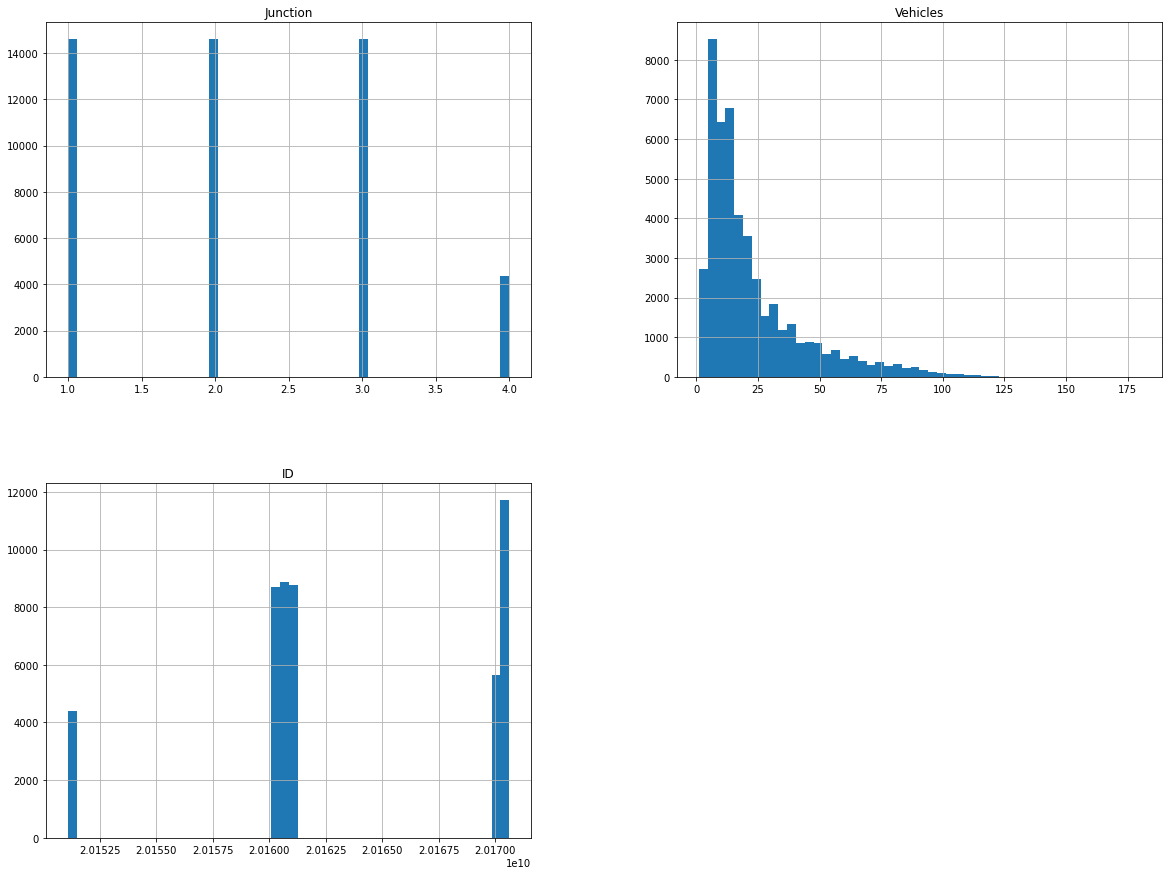

In [7]:
#plotting a histogram for each numerical attribute
data.hist(bins=50, figsize=(20,15))

In [8]:
#creating a  copy of the train dataset
copydata = data.copy()
copydata

,DateTime,Junction,Vehicles,ID
0,11/1/2015 0:00,1,15,20151101001
1,11/1/2015 1:00,1,13,20151101011
2,11/1/2015 2:00,1,10,20151101021
3,11/1/2015 3:00,1,7,20151101031
4,11/1/2015 4:00,1,9,20151101041
...,...,...,...,...
48115,6/30/2017 19:00,4,11,20170630194
48116,6/30/2017 20:00,4,30,20170630204
48117,6/30/2017 21:00,4,16,20170630214
48118,6/30/2017 22:00,4,22,20170630224


## Splitting data into Train and Test data

In [ ]:
def split_train_test(copydata, test_ratio):
    shuffled_indices = np.random.permutation(len(copydata))
    test_set_size = int(len(copydata) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return copydata.iloc[train_indices], copydata.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(copydata, 0.2)
print(len(train_set), "train +", len(test_set), "test")

38496 train + 9624 test


In [59]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(copydata, test_size=0.2, random_state=42)

In [60]:
test_set.head()

,Junction,Vehicles,ID,DateTime_year,DateTime_month,DateTime_hour
24632,2,9,20161223082,2016,12,8
36428,3,97,20160828203,2016,8,20
42150,3,13,20170424063,2017,4,6
23885,2,11,20161122052,2016,11,5
2174,1,24,20160130141,2016,1,14


## Visualizing the data

<AxesSubplot:xlabel='Vehicles', ylabel='Junction'>

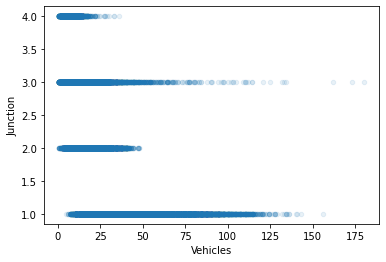

In [11]:
#visualizing the dataset using scatterplot, highlighting high-density areas
copydata.plot(kind="scatter", x="Vehicles", y="Junction", alpha=0.1)

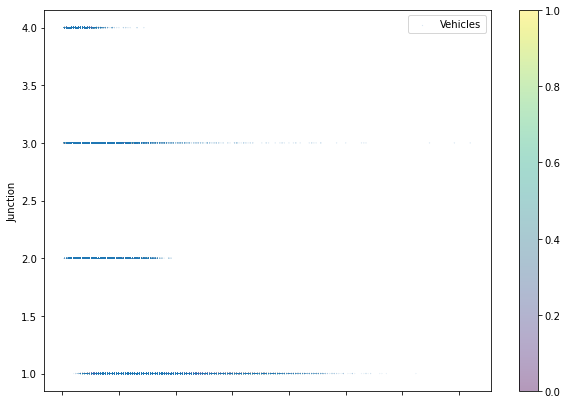

In [12]:
copydata.plot(kind="scatter", x="Vehicles", y="Junction", alpha=0.4,
s=copydata["Junction"]/100, label="Vehicles", figsize=(10,7), cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

## Checking for correlation

In [13]:
#Looking for correlation
corr_matrix = copydata.corr()

In [14]:
#correlating other attributes with the Junctions
corr_matrix["Junction"].sort_values(ascending=False)

Junction    1.000000
ID          0.221876
Vehicles   -0.613787
Name: Junction, dtype: float64

array([[<AxesSubplot:xlabel='Junction', ylabel='Junction'>,
        <AxesSubplot:xlabel='Vehicles', ylabel='Junction'>,
        <AxesSubplot:xlabel='ID', ylabel='Junction'>],
       [<AxesSubplot:xlabel='Junction', ylabel='Vehicles'>,
        <AxesSubplot:xlabel='Vehicles', ylabel='Vehicles'>,
        <AxesSubplot:xlabel='ID', ylabel='Vehicles'>],
       [<AxesSubplot:xlabel='Junction', ylabel='ID'>,
        <AxesSubplot:xlabel='Vehicles', ylabel='ID'>,
        <AxesSubplot:xlabel='ID', ylabel='ID'>]], dtype=object)

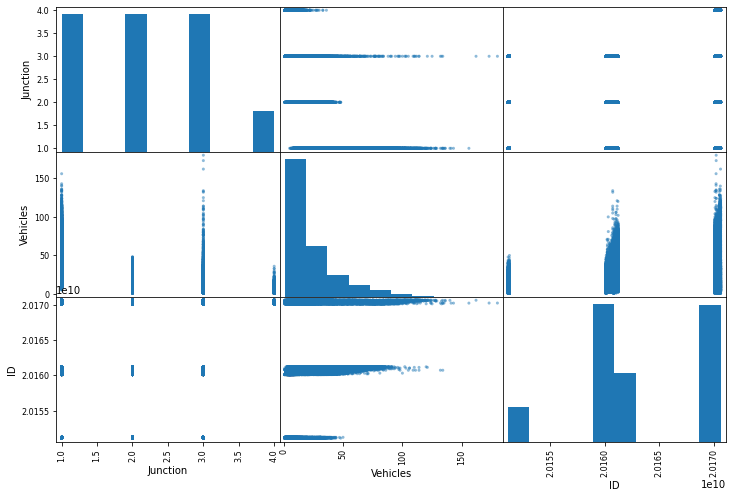

In [15]:
#another way to check for correlation between attribute is using pandas scatter matric=x function
from pandas.plotting import scatter_matrix
attributes = ["DateTime", "Junction", "Vehicles", "ID"] 
scatter_matrix(copydata[attributes], figsize=(12, 8))

## Checking for duplicates and null values

In [16]:
#Checking for duplicate rows
dupRows = data.duplicated().sum()
print("there are " + str(dupRows) + " duplicated rows in the dataframe.")

there are 0 duplicated rows in the dataframe.


In [17]:
#checking for null data 
data.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [18]:
#Decomposing the time series
copydata['DateTime'] = pd.to_datetime(copydata['DateTime'], format='%m/%d/%Y %H:%M')

In [20]:
copydata['DateTime_year'] = copydata['DateTime'].dt.year
copydata['DateTime_month'] = copydata['DateTime'].dt.month
copydata['DateTime_day'] = copydata['DateTime'].dt.day
copydata['DateTime_hour'] = copydata['DateTime'].dt.hour
copydata['DateTime_minute'] = copydata['DateTime'].dt.minute
copydata['DateTime_sec'] = copydata['DateTime'].dt.second
copydata

,DateTime,Junction,Vehicles,ID,DateTime_year,DateTime_month,DateTime_day,DateTime_hour,DateTime_minute,DateTime_sec
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,0,0
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,0,0
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,0,0
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,0,0
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,0,0
48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,0,0
48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,0,0
48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,0,0


In [21]:
copydata.drop(['DateTime','DateTime_minute', 'DateTime_sec','DateTime_day'], axis = 1, inplace = True)

In [23]:
data = copydata.copy()

In [24]:
copydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Junction        48120 non-null  int64
 1   Vehicles        48120 non-null  int64
 2   ID              48120 non-null  int64
 3   DateTime_year   48120 non-null  int64
 4   DateTime_month  48120 non-null  int64
 5   DateTime_hour   48120 non-null  int64
dtypes: int64(6)
memory usage: 2.2 MB


In [62]:
from sklearn.pipeline import Pipeline


## Building Models

In [25]:
data = copydata.drop("Junction", axis=1)
data_labels = copydata["Junction"].copy()

In [26]:
#Declaring Variables
y = copydata["Junction"]
x = copydata.drop(columns='Junction')

In [27]:
X_train = copydata.drop("Junction", axis= 1)
y_train = copydata["Junction"]

## Linear Regression Model

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [30]:
predicted_values = model.predict(X_train)

In [31]:
#calculating the linear regression score
model.score(X_train, y_train)

0.5522162358238758

In [32]:
#Trying a few instances on the training set
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
print("Predictions:", model.predict(some_data))

Predictions: [1.40249236 1.4961695  1.62507312 1.75397673 1.70674796]


In [33]:
print("Labels:", list(some_labels))

Labels: [1, 1, 1, 1, 1]


## Measuring RMSE of the regression model

In [34]:
#Measuring the regression model's RMSE on the train data
from sklearn.metrics import mean_squared_error
traffic_predictions = model.predict(X_train)
lin_mse = mean_squared_error(y_train, traffic_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.647047382127258

## Decision Tree Regressor

In [35]:
from sklearn.tree import DecisionTreeRegressor

In [36]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [37]:
traffic_predictions = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, traffic_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.1542720820878512

## Better Evaluation Using Cross-Validation

In [38]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, X_train, y_train,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [39]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [40]:
display_scores(tree_rmse_scores)

Scores: [1.80736795 1.87598686 1.90883506 1.01577336 0.99875234 1.09806258
 1.19848354 1.11475314 1.04742589 1.24459439]
Mean: 1.3310035108768667
Standard deviation: 0.3569383932180468


In [41]:
lin_scores = cross_val_score(model, X_train, y_train,
    scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.86654878 0.62263606 0.77271372 0.37613783 0.56563008 0.89663929
 1.17911784 0.76525724 0.47106155 1.18360356]
Mean: 0.7699345961278439
Standard deviation: 0.25919280551357177


## Using Random Forest Regressor

In [42]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [43]:
traffic_predictions = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, traffic_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.23596367277581348

In [44]:
display_scores(forest_rmse)

Scores: 0.23596367277581348
Mean: 0.23596367277581348
Standard deviation: 0.0


## Fine-tuning my model

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(X_train, y_train)

C:\Users\ayode\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ayode\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ayode\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\ayode\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\ayode\anaconda3\lib\site-packages\jo

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [47]:
grid_search.best_params_
{'max_features': 8, 'n_estimators': 30}

{'max_features': 8, 'n_estimators': 30}

In [48]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
   print(np.sqrt(-mean_score), params) 

1.4274589306478147 {'max_features': 2, 'n_estimators': 3}
1.4163599554345476 {'max_features': 2, 'n_estimators': 10}
1.4150166927082821 {'max_features': 2, 'n_estimators': 30}
1.4359929686957758 {'max_features': 4, 'n_estimators': 3}
1.4402157520867933 {'max_features': 4, 'n_estimators': 10}
1.4418261486165675 {'max_features': 4, 'n_estimators': 30}
nan {'max_features': 6, 'n_estimators': 3}
nan {'max_features': 6, 'n_estimators': 10}
nan {'max_features': 6, 'n_estimators': 30}
nan {'max_features': 8, 'n_estimators': 3}
nan {'max_features': 8, 'n_estimators': 10}
nan {'max_features': 8, 'n_estimators': 30}
1.4070882980559207 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
1.4385842676765335 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
1.4506802072613478 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
1.444104153891726 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
1.4554782887221067 {'bootstrap': False, 'max_features': 4, 'n_estimators'

In [54]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.061616,0.007130,0.002880,0.000509,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.427732,-1.950181,...,-2.037639,0.847450,4,-0.080307,-0.076140,-0.053191,-0.037885,-0.062412,-0.061987,0.015456
1,0.195647,0.020274,0.005397,0.001240,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.408458,-1.849999,...,-2.006076,0.848644,3,-0.056444,-0.052866,-0.036986,-0.026111,-0.044163,-0.043314,0.010957
2,0.546041,0.058202,0.012325,0.001252,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-3.356297,-1.906259,...,-2.002272,0.830592,2,-0.050033,-0.045903,-0.032077,-0.022916,-0.039206,-0.038027,0.009709
3,0.092732,0.011099,0.001999,0.000009,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.482993,-2.067643,...,-2.062076,0.850425,5,-0.079147,-0.074987,-0.052671,-0.036250,-0.062672,-0.061145,0.015554
4,0.294578,0.031142,0.005479,0.000739,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-3.527416,-2.044354,...,-2.074221,0.873460,7,-0.056192,-0.052340,-0.036318,-0.025787,-0.043991,-0.042926,0.010983
5,0.860887,0.114457,0.012932,0.001488,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-3.512334,-2.089061,...,-2.078863,0.871136,8,-0.049532,-0.045903,-0.031724,-0.022234,-0.038446,-0.037568,0.009825
6,0.005244,0.001124,0.000000,0.000000,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",NaN,NaN,...,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.007468,0.000633,0.000000,0.000000,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",NaN,NaN,...,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.012050,0.000827,0.000000,0.000000,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",NaN,NaN,...,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.005771,0.000236,0.000000,0.000000,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",NaN,NaN,...,NaN,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analyzing the best models and their errors

In [49]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.64558128, 0.18437686, 0.02997367, 0.01613853, 0.12392966])

## Evaluating my system on the Test set

In [50]:
X_test = test_set.drop("Junction", axis= 1)
y_test = test_set["Junction"]

In [68]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("Junction", axis=1)
y_test = test_set["Junction"].copy()

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_mse)

0.023253498198947075


In [70]:
final_rmse

0.15249097743455864

We can compute a 95% confidence interval for the test RMSE

In [72]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.1462231, 0.1585112])

I computed the interval manually like this:

In [73]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(0.14622310488818438, 0.15851119832602764)

Alternatively, I used a z-scores rather than t-scores:

In [75]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(0.14622391014330618, 0.1585104554920481)